# PCA on weather & time features for power-outage modeling (2014–2020)

**Goal**: Use PCA to 
    (i) understand dominant patterns in weather/time
    (ii) compress them into a small number of orthogonal factors ("PCs")
    (iii) export those PCs for downstream modeling (probability of outage)

**What this is not**: We are not training a predictive model here. We’re purely just preparing and inspecting features

**Key questions**:

* How many components (k) are enough to summarize weather/time drivers?

* What do the first PCs "mean" (which features load heavily)?

* Do PCs separate regimes across season, region, or state?

**Leakage note**: For anything that will flow into a model evaluation, fit scaler + PCA on training years only (e.g., 2014–2018) and transform 2019 + 2020 later

## 0. Load Neccessary Libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

## 1. Data Loading

In [17]:
# Path to processed data directory
PROCESSED_DATA = "../../data/processed"

# Load the integrated processed dataset
dt = pd.read_csv(f"{PROCESSED_DATA}/integrated_dataset.csv")

# Sneak peak of the data
dt.head(20)

,fips_code,date,prcp,tmax,tmin,outage_occurred,customers_out,county,state,run_start_time,year,month,day_of_week,day_name,season,outage_hour,region
0,1001,2014-01-01,0.00,7.92,3.12,0,0,Autauga,Alabama,NaN,2014,1,2,Wednesday,Winter,NaN,Southeast
1,1001,2014-01-02,7.54,9.14,4.07,0,0,Autauga,Alabama,NaN,2014,1,3,Thursday,Winter,NaN,Southeast
2,1001,2014-01-03,1.41,12.62,-4.65,0,0,Autauga,Alabama,NaN,2014,1,4,Friday,Winter,NaN,Southeast
3,1001,2014-01-04,0.00,4.46,-5.44,0,0,Autauga,Alabama,NaN,2014,1,5,Saturday,Winter,NaN,Southeast
4,1001,2014-01-05,0.00,9.72,-4.71,0,0,Autauga,Alabama,NaN,2014,1,6,Sunday,Winter,NaN,Southeast
5,1001,2014-01-06,2.39,15.71,-3.26,0,0,Autauga,Alabama,NaN,2014,1,0,Monday,Winter,NaN,Southeast
6,1001,2014-01-07,0.00,-0.88,-11.17,0,0,Autauga,Alabama,NaN,2014,1,1,Tuesday,Winter,NaN,Southeast
7,1001,2014-01-08,0.00,-1.97,-11.40,0,0,Autauga,Alabama,NaN,2014,1,2,Wednesday,Winter,NaN,Southeast
8,1001,2014-01-09,0.00,6.69,-8.77,0,0,Autauga,Alabama,NaN,2014,1,3,Thursday,Winter,NaN,Southeast
9,1001,2014-01-10,3.90,10.84,-1.10,0,0,Autauga,Alabama,NaN,2014,1,4,Friday,Winter,NaN,Southeast


In [18]:
# Data shape
dt.shape

(3976135, 17)

In [19]:
# Different columns in dt
dt.columns

Index(['fips_code', 'date', 'prcp', 'tmax', 'tmin', 'outage_occurred',
       'customers_out', 'county', 'state', 'run_start_time', 'year', 'month',
       'day_of_week', 'day_name', 'season', 'outage_hour', 'region'],
      dtype='object')

In [20]:
# Number of missing values in each column
dt.isna().sum()

fips_code                0
date                     0
prcp                     0
tmax                     0
tmin                     0
outage_occurred          0
customers_out            0
county                   0
state                    0
run_start_time     1991833
year                     0
month                    0
day_of_week              0
day_name                 0
season                   0
outage_hour        1991833
region                   0
dtype: int64

**Data Scope & Columns Summary**

We have daily county-level records with:

* *Weather numeric*: `prcp`, `tmax`, `tmin`

* *Time-of-*: `month`, `day_of_week`, `outage_hour` (we will encode these cyclically)

* *Categorical context*: `region`, `state`, `season` (kept outside PCA for Option A; optionally included in Option B)

* *Targets*: `outage_occurred`, `customers_out` (never used in PCA)

* *IDs/dates*: `fips_code`, `county`, `date`, `run_start_time`, `year`, `day_name` (not used in PCA)

## 2. Train/Validation/Test Split

Here, we first split our dataset by time (fit on < 2019 and hold out 2019 & 2020 to transform later). Then, we implement cyclic encodings for `month` and `day_of_week`so distances respect the wrap-around (Dec ~ Jan, Sun ~ Mon). Notice that, while we do want to include `outage_hour`, there is a large number of missing values in such column and thus it will not work in PCA. So, we will exclude this out for the moment.

In [64]:
# Ensure we have correct datatype for date and year columns
dt["date"] = pd.to_datetime(dt["date"])
dt["year"] = dt["date"].dt.year
TARGET = "outage_occurred"

train = dt[dt["year"] <= 2018]      # Years in range 2014-2018
test  = dt[dt["year"] >= 2019]      # Include 2018 & 2019

X_train, y_train = train.drop(columns=[TARGET]), train[TARGET]
X_test,  y_test  = test.drop(columns=[TARGET]), test[TARGET]

In [67]:
# Define numerical and categorical columns in the data
num_cols = ["prcp", "tmax", "tmin", "month", "day_of_week"]     # Could not include "outage_hour" since it has missing values
cat_cols = ["region","state","season"]

In [68]:
# Cyclic encodings for temporal fields (month, DOW, hour)
def add_cyc(Xdf):
    X = Xdf.copy()

    X["month_sin"] = np.sin(2 * np.pi * X["month"] / 12)
    X["month_cos"] = np.cos(2 * np.pi * X["month"] /12)

    X["dow_sin"]   = np.sin(2 * np.pi * X["day_of_week"] / 7)
    X["dow_cos"]   = np.cos(2 * np.pi * X["day_of_week"] / 7)

    # X["hour_sin"]  = np.sin(2 * np.pi * X["outage_hour"] / 24)
    # X["hour_cos"]  = np.cos(2 * np.pi * X["outage_hour"] / 24)
    
    return X[["prcp","tmax","tmin","month_sin","month_cos","dow_sin","dow_cos"]]

In [70]:
def cyc_feature_names(transformer, input_features):
    # keep non-cyclic numeric features + replace cyc vars with their sin/cos pair
    base = [c for c in input_features if c not in ("month", "day_of_week")]
    return np.array(base + [
        "month_sin", "month_cos",
        "dow_sin", "dow_cos",
        # "hour_sin", "hour_cos",
    ])

## 3. PCA Implementation

### a. Only Include Numerical Values

In [71]:
# Add cyclic features, then standardize (PCA needs standardized inputs)
num_pre = Pipeline([
    (
        "cyc", 
        FunctionTransformer(
            add_cyc, 
            validate=False, 
            feature_names_out=cyc_feature_names
        )
    ),
    (
        "scaler", StandardScaler()
    ),
])

num_pre

Pipeline(steps=[('cyc',
                 FunctionTransformer(feature_names_out=<function cyc_feature_names at 0x31a6339c0>,
                                     func=<function add_cyc at 0x31a633b00>)),
                ('scaler', StandardScaler())])

In [72]:
# Apply the numeric preprocessor to the specified numeric columns
pre = ColumnTransformer([
    ("num", num_pre, num_cols),
])

In [73]:
# Preprocess -> PCA (keep all comps for now to inspect variance)
pca = Pipeline([
    ("pre", pre),
    ("pca", PCA(n_components=None, random_state=42)),
]).fit(train)           # Fit this on train set only

In [74]:
# Explained variance
evr = pca.named_steps["pca"].explained_variance_ratio_
print("First 8 EV ratios:", np.round(evr[:8], 3))
print("Cumulative:", np.round(evr.cumsum()[:8], 3))

First 8 EV ratios: [0.379 0.145 0.143 0.143 0.14  0.042 0.008]
Cumulative: [0.379 0.524 0.667 0.81  0.95  0.992 1.   ]


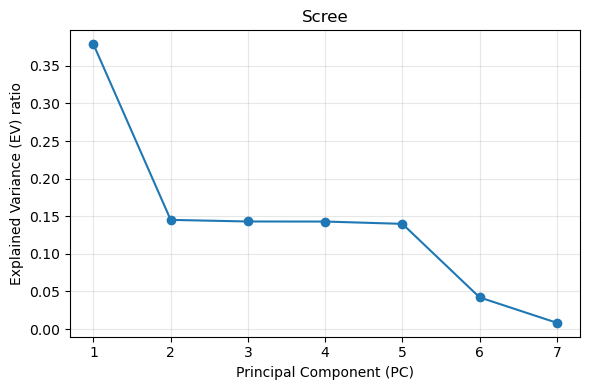

In [ ]:
# Scree Plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(evr)+1), evr, marker="o")
plt.xlabel("Principal Component (PC)")
plt.ylabel("Explained Variance (EV) ratio")
plt.title("Scree")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

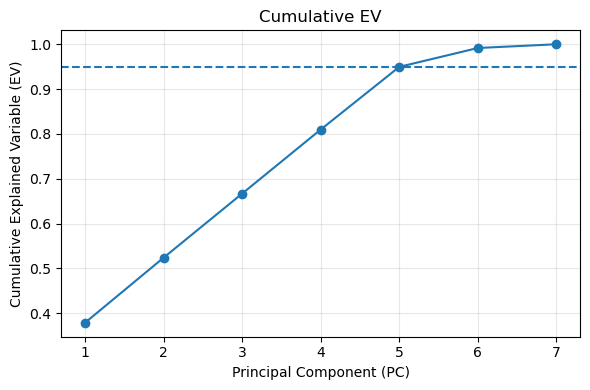

In [86]:
# Cumulative EV plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(evr)+1), evr.cumsum(), marker="o")
plt.axhline(0.95, ls="--")
plt.xlabel("Principal Component (PC)")
plt.ylabel("Cumulative Explained Variable (EV)")
plt.title("Cumulative EV") 
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [63]:
# Loadings (contribution of original numeric features to PCs)
loadings = pd.DataFrame(
    pca.named_steps["pca"].components_.T,
    index=["prcp","tmax","tmin","month_sin","month_cos","dow_sin","dow_cos"],
    columns=[f"PC{i+1}" for i in range(len(evr))]
)
loadings.abs().sort_values("PC1", ascending=False).head(8)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
tmin,0.591036,0.000908,0.018666,0.002711,0.027467,0.385891,0.707568
tmax,0.588699,0.043148,0.024270,0.004731,0.072071,0.391528,0.701763
month_cos,0.446656,0.246085,0.443636,0.109719,0.254233,0.682656,0.020887
month_sin,0.309853,0.477077,0.608462,0.142586,0.239386,0.477456,0.023707
prcp,0.092276,0.625990,0.086205,0.028584,0.762748,0.060987,0.076614
dow_cos,0.006770,0.312677,0.149351,0.886027,0.307853,0.007588,0.002698
dow_sin,0.006162,0.469411,0.634261,0.426310,0.442215,0.005749,0.000546


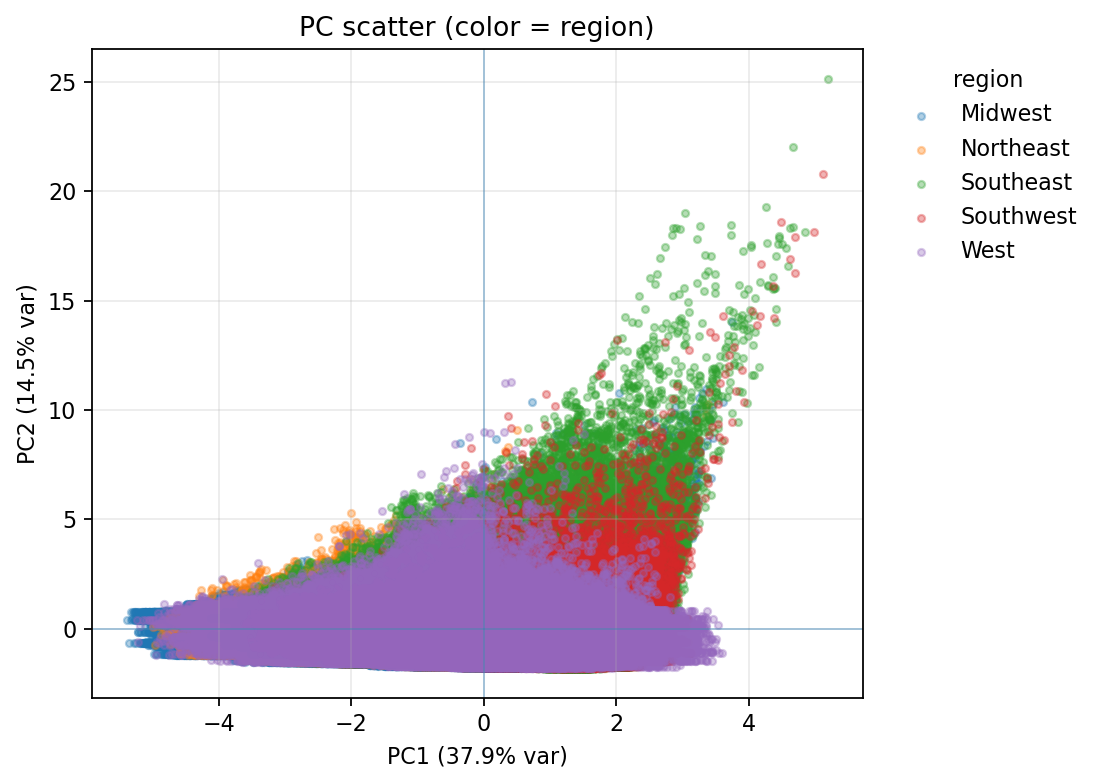

In [78]:
# PC scores
Z_train = pca.transform(train)
evr = pca.named_steps["pca"].explained_variance_ratio_

# Choose a hue column (e.g., 'season', 'region', or 'state')
hue = "region"
cats = pd.Categorical(train[hue]).categories  # keeps a consistent order

plt.figure(figsize=(7,5), dpi=160)

# Plot each category separately so you get a proper legend (no colormap tricks)
for cat in cats:
    m = (train[hue] == cat)
    plt.scatter(
        Z_train[m, 0], Z_train[m, 1],
        s=10, alpha=0.35, label=str(cat), rasterized=True
    )

# Axes + helpers
plt.axhline(0, lw=0.8, alpha=0.4)
plt.axvline(0, lw=0.8, alpha=0.4)
plt.grid(True, alpha=0.25)

# Show explained variance on axes
plt.xlabel(f"PC1 ({evr[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({evr[1]*100:.1f}% var)")
plt.title(f"PC scatter (color = {hue})")

# Legend outside the plot
plt.legend(title=hue, frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

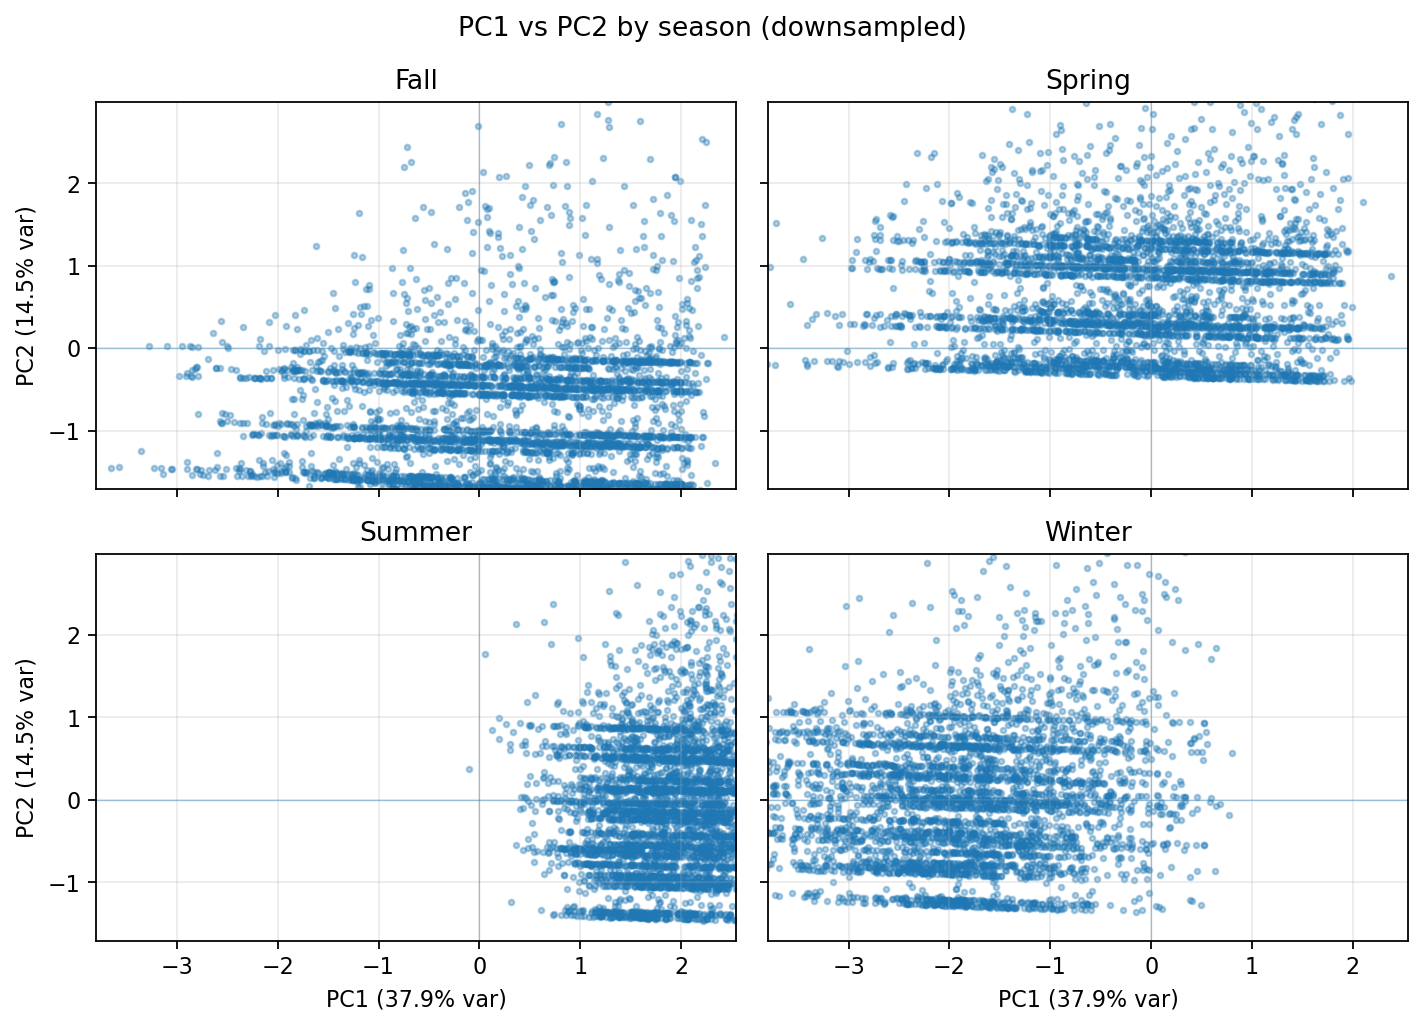

In [79]:
# Stratified downsample to avoid blobs
rng = np.random.default_rng(0)
hue = "season"
cats = pd.Categorical(train[hue]).categories
Z = pca.transform(train)

# Choose a max per category
n_per = 4000
idxs = []
for cat in cats:
    I = np.flatnonzero(train[hue].values == cat)
    if len(I) > n_per:
        I = rng.choice(I, n_per, replace=False)
    idxs.append(I)
idx = np.concatenate(idxs)

# Shared limits (robust to outliers)
xlo, xhi = np.percentile(Z[idx,0], [1, 99])
ylo, yhi = np.percentile(Z[idx,1], [1, 99])

fig, axes = plt.subplots(2, 2, figsize=(9,6.5), dpi=160, sharex=True, sharey=True)
axes = axes.ravel()
for ax, cat in zip(axes, cats):
    m = (train[hue].values[idx] == cat)
    ax.scatter(Z[idx[m],0], Z[idx[m],1], s=6, alpha=0.35, rasterized=True)
    ax.set_title(str(cat))
    ax.axhline(0, lw=0.6, alpha=0.4); ax.axvline(0, lw=0.6, alpha=0.4)
    ax.grid(True, alpha=0.25)

for ax in axes[::2]:  # left column
    ax.set_ylabel(f"PC2 ({evr[1]*100:.1f}% var)")
for ax in axes[2:]:
    ax.set_xlabel(f"PC1 ({evr[0]*100:.1f}% var)")

axes[0].set_xlim(xlo, xhi); axes[0].set_ylim(ylo, yhi)
fig.suptitle(f"PC1 vs PC2 by {hue} (downsampled)", y=0.98)
plt.tight_layout(); plt.show()
